<a href="https://colab.research.google.com/github/saisriy/ShroudX/blob/main/texttoimagestego.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.0 MB/s eta 0:00:00


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import os
from Crypto.Cipher import AES
import base64
import secrets

In [3]:
def Read_image(image_path) :
    image = Image.open(image_path)
    image = image.convert("RGB")
    pixels = image.load()
    return image,pixels

def Show_image(image) :
    plt.imshow(image)
    plt.axis("off")
    plt.show()

def get_image_size(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return width, height

In [4]:
def generate_key():
    """Generates a secure 32-byte key and returns it as a base64 string."""
    return base64.b64encode(secrets.token_bytes(32)).decode()

#  PKCS7 Padding
def pad_message(message):
    """Pads the message to be a multiple of 16 bytes using PKCS7 padding."""
    message_bytes = message.encode()  # Convert string to bytes
    padding_length = 16 - (len(message_bytes) % 16)
    return message_bytes + bytes([padding_length] * padding_length)

#  PKCS7 Unpadding
def unpad_message(padded_message):
    """Removes PKCS7 padding after decryption."""
    padding_length = padded_message[-1]  # Get last byte
    if padding_length < 1 or padding_length > 16:
        raise ValueError("Invalid padding detected!")
    return padded_message[:-padding_length]  # Remove padding

#  Encrypt Message using AES-CBC
def encrypt_message(message, key):
    key = base64.b64decode(key)
    if len(key) != 32:
        raise ValueError("Invalid key length. AES-256 requires a 32-byte key.")

    # Generate a random 16-byte IV
    iv = os.urandom(16)

    # Create AES cipher in CBC mode
    cipher = AES.new(key, AES.MODE_CBC, iv)

    # Apply PKCS7 padding
    padded_message = pad_message(message)

    # Encrypt the message
    encrypted = cipher.encrypt(padded_message)

    # Return IV + encrypted message in Base64 format
    return base64.b64encode(iv + encrypted).decode()

#  Decrypt Message using AES-CBC
def decrypt_message(encrypted_message, key):
    key = base64.b64decode(key)  # Convert Base64 back to bytes
    encrypted_data = base64.b64decode(encrypted_message)

    print("Decoded Key Length:", len(key))  # Should be 32 bytes
    print("Encrypted Data Length:", len(encrypted_data))  # Should be > 16 bytes
    print("Raw Encrypted Data:", encrypted_data[:64])  # Print first few bytes
    iv, encrypted_text = encrypted_data[:16], encrypted_data[16:]
    cipher = AES.new(key, AES.MODE_CBC, iv)
    decrypted = cipher.decrypt(encrypted_text)
    print("Decrypted Message (Before Unpadding):", decrypted)
    final_message= unpad_message(decrypted).decode()
    print(f"final message: {final_message}")
    return final_message

In [5]:
key = generate_key()  #  Generate Key (Base64 format)
message = "Hello, AES-CBC!"

encrypted_msg = encrypt_message(message, key)  #  Encrypt
decrypted_msg = decrypt_message(encrypted_msg, key)  #  Decrypt

assert decrypted_msg == message, " Decryption Failed!"
print(" Success! Decrypted Message:", decrypted_msg)

Decoded Key Length: 32
Encrypted Data Length: 32
Raw Encrypted Data: b'g\x8f\xa9"\x12(\x1cQ\xde\xc5\xdf\xedn\xb7\xff\x1b\x8b\xbd\xfa\xf90V\xc3\x14P\xc0\x82U\xa4Xo\xa8'
Decrypted Message (Before Unpadding): b'Hello, AES-CBC!\x01'
final message: Hello, AES-CBC!
 Success! Decrypted Message: Hello, AES-CBC!


In [14]:
def encode_message(image_path, message):
    image,pixels = Read_image(image_path)
    """Encodes an AES-encrypted message inside an image using LSB steganography."""

    # Generate a random key
    secret_key = generate_key()
    print("Generated Secret Key:", secret_key)  # Key must be saved to decode

    # Encrypt the message using the generated key
    encrypted_message = encrypt_message(message, secret_key)
    print(f"Encrypted message :{encrypted_message}")
    print(f"secret key {secret_key}")
    # Convert message to binary and add delimiter
    binary_message = ''.join(format(ord(char), '08b') for char in encrypted_message)
    binary_message += '1111111111111110'  # Special delimiter to mark end

    width, height = image.size
    index = 0

    for y in range(height):
        for x in range(width):
            if index < len(binary_message):
                r, g, b = pixels[x, y]
                # Modify the least significant bit (LSB) of the red channel
                r = (r & ~1) | int(binary_message[index])
                pixels[x, y] = (r, g, b)
                index += 1

    return image,secret_key



In [15]:
def start_encode(image_path,message_or_file,output_path) :
  if os.path.isfile(message_or_file):
        try:
            with open(message_or_file, "r", encoding="utf-8") as file:
                message = file.read().strip()
        except FileNotFoundError:
            print(f"Error: File '{message_or_file}' not found.")
            return None
  else:
        message = message_or_file
  width, height = get_image_size(image_path)
  print(f"width {width} height {height}")
  char_can_be_stored= ((width*height)//8) - 16
  chars= len(message)
  print(f"chars_can_be_stored {char_can_be_stored}")
  print(f"chars_entered {chars}")
  if chars> char_can_be_stored:
   print("entire message cant be stored")
   return None
  encoded_image,secret_key = encode_message(image_path, message)
  response= 'n'
  if response=='y' :
    # Save in PNG format to prevent compression artifacts
    encoded_image.save(output_path, "PNG")
    print(f"Stego image saved as {output_path}")

    # Download the image using Colab
    files.download(output_path)
  else :
   print("Image not saved")
  return encoded_image,secret_key

width 256 height 256
chars_can_be_stored 8176
chars_entered 3105
Generated Secret Key: g7TytHg/wi+V4Gaf56N7lo7azB2YMw/9GhuCHmLMTAg=
Encrypted message :SecIkLIXhZA/LnZe2pyCF0aAkQv4aTBge2M/rXuCaNWve2OGu6SiaKTbyJonzceqWDwpFmorYLBXL7+ue+n9B3UxqS3dnrUJjxMF9EH2KSi4aK6GRJL6L81qRkZT0O2STAqoDgq65X8XfKw+j3dadX8uXjilJjhrRoyADH2tHfHn0eEHYt2FbTfz77h1IBGieGJt1GQZHIM7oDPa0alIwXzdgc87ZFP+H+qMdJnIS3RaDuNQuGl/bPQd5zXx4av9Ypcfonw7kSwADnPwU6SnZ4WQWVnXHsocQIWpq0oyWJ310C9Ts7UgtEKKdf0koWHPvqZ0whYVcnr85Kv8X+2u7BDhA7KvxkXauvaEQqzbGG28rU3+AVF9XX5XALqd6G/HPzhVwMJzvcCVJ0GgjVbfPim5IPbbrWHrrYmPH8tEonUXxXFHUo/S1v/sOIBninvCaRsz8c9pMW+8daM/NBeH1qSWH89lswUD4dpJfM4f6b0x9K7aZGTUCHcnjWsgqbu3pkHw9pp+gLxEKxccpWwm9oTdGOYoYULEcNCPzqTDPYfus5ZHXahXagjYz4hHNJuPsLrwd+LyfQA3cfCmc7lx30ZT2Uew3dBTSrZNmZwpmo3SnPFdvp0G0DuIhwem852CBktVP6XxtjwYZuNGkOmHP6opImw1P0dpHhTzuGgdxZTeHfL/CBImvTroivZg8B7LC0i/T5jS69XX2IoJv5FDHuJ5/TbrXlM7Ob1p6Hfck+eAvnIEXcb9VKzTTNMBwJ4m4AQE90ePgwbsKiVK52j2llEMNEaJ8N21c+INmeghS3WU+0RSzvYaaOL1nKNClUDLrv4OC1Xeab4ESfku4

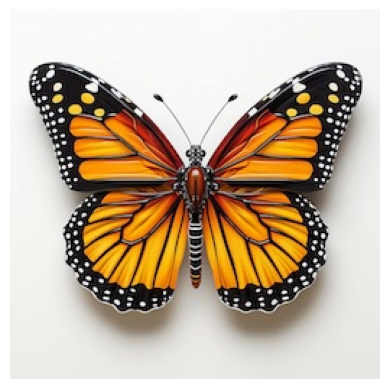

In [16]:
image_path = "256_butter.jpg"
  # Replace with your actual image path
message= "randomtext.txt"
output_path= "butter_new.png"
encoded_image,abc=start_encode(image_path, message, output_path)
if not encoded_image:
  print("Error: Encoding failed.")
else:
 Show_image(encoded_image)

In [17]:
def decode_message(image_path, secret_key):
    if isinstance(image_path, str):
        encoded_image = Image.open(image_path).convert("RGB")
    elif isinstance(image_path, Image.Image):
        encoded_image = image_path.convert("RGB")
    else:
        raise ValueError("Invalid input: Provide either an image file path or a PIL Image object")

    #encoded_image = Image.open(image_path).convert("RGB")
    pixels = encoded_image.load()
    width, height = encoded_image.size

    binary_message = ""

    for y in range(height):
        for x in range(width):
            r, _, _ = pixels[x, y]
            binary_message += str(r & 1)

    # Stop at delimiter and ensure it's a valid Base64 string length
    delimiter_index = binary_message.find("1111111111111110")
    if delimiter_index != -1:
        binary_message = binary_message[:delimiter_index]
        # Pad with zeros if necessary to make the length a multiple of 8 (for byte conversion)
        binary_message += '0' * (8 - (len(binary_message) % 8))  # Padding
    else:
        print("Warning: Delimiter not found. The message might be incomplete.")

    chars = [binary_message[i:i+8] for i in range(0, len(binary_message), 8)]
    message = ''.join(chr(int(char, 2)) for char in chars)
    # Check if message is valid Base64 before decoding
    # Add padding if required and try decoding
    try:
        message = message.rstrip('\x00')  # remove zero padding
        #print(f"message:{message}")
        #print(f"message in bytes:{base64.b64decode(message)}")
        decrypted_message = decrypt_message(message, secret_key)
        return decrypted_message

    except (base64.binascii.Error, ValueError) as e:
      print(f"Error decoding message: {e}")
      print(f"binary_message: {binary_message}")  # Print for debugging
      return None

In [18]:
# Use the downloaded stego image for decoding
#image_to_decode= encoded_image
print(abc)
decoded_message = decode_message(encoded_image,abc)
print("Decoded Message:", decoded_message)

g7TytHg/wi+V4Gaf56N7lo7azB2YMw/9GhuCHmLMTAg=
Decoded Key Length: 32
Encrypted Data Length: 3136
Raw Encrypted Data: b"I\xe7\x08\x90\xb2\x17\x85\x90?.v^\xda\x9c\x82\x17F\x80\x91\x0b\xf8i0`{c?\xad{\x82h\xd5\xaf{c\x86\xbb\xa4\xa2h\xa4\xdb\xc8\x9a'\xcd\xc7\xaaX<)\x16j+`\xb0W/\xbf\xae{\xe9\xfd\x07"
Decrypted Message (Before Unpadding): b'Ipsum?\nLorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry\'s standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.\n\nWhy do we use it?\nIt is a long established fact that a reader will be distrac

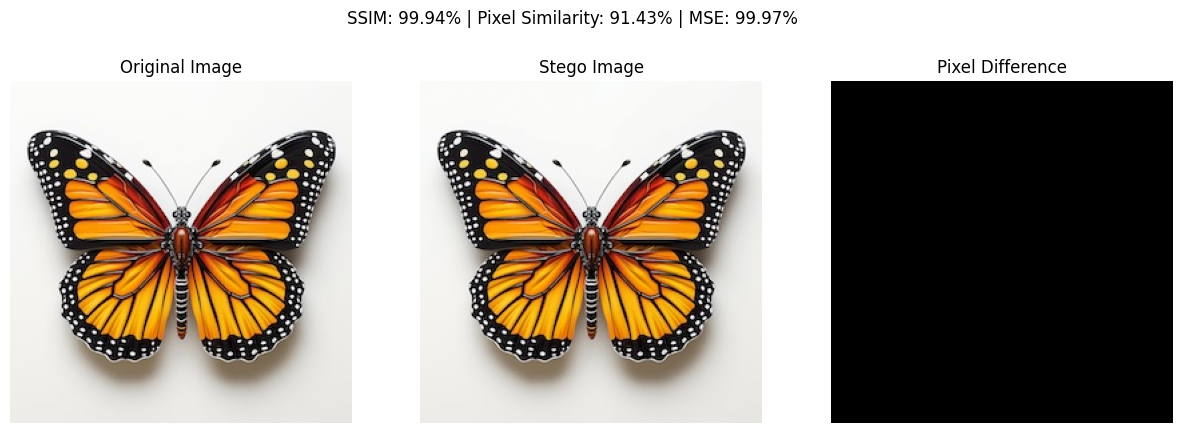

In [19]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from PIL import Image

def pixel_difference(image1, image2):
    """Calculate the percentage of changed pixels between two images."""
    diff = cv2.absdiff(image1, image2)
    non_zero_count = np.count_nonzero(diff)
    total_pixels = image1.size

    similarity = ((total_pixels - non_zero_count) / total_pixels) * 100
    return round(similarity, 2), diff  # Return similarity score and difference image

def structural_similarity(image1, image2):
    """Compute SSIM for real-world similarity."""
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    score, _ = ssim(gray1, gray2, full=True)
    return round(score * 100, 2)  # Convert to percentage

def mse_similarity(image1, image2):
    """Calculate Mean Squared Error (MSE) to measure image difference."""
    err = np.sum((image1.astype("float") - image2.astype("float")) ** 2)
    err /= float(image1.shape[0] * image1.shape[1] * image1.shape[2])

    return round(100 - (err / 255) * 100, 2)  # Convert MSE to percentage similarity

def load_image(image):
    """Load an image from path or convert to OpenCV format if needed."""
    if isinstance(image, str):
        img = cv2.imread(image)  # Load image as BGR
    elif isinstance(image, Image.Image):
        img = np.array(image)  # Convert PIL Image to NumPy
        if img.shape[-1] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)  # Convert RGBA → BGR
        elif img.shape[-1] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB → BGR
    else:
        img = image  # Already a NumPy array

    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)  # Ensure uint8 format
    return img


def compare_images(image1, image2):
    """Load images, compute similarities, and display them side by side."""
    img1 = load_image(image1)
    img2 = load_image(image2)

    if img1 is None or img2 is None:
        print("Error: One or both images could not be loaded!")
        return

    if img1.shape != img2.shape:
        print("Error: Image dimensions do not match!")
        return

    # Compute similarity scores
    pixel_sim, diff_img = pixel_difference(img1, img2)
    ssim_score = structural_similarity(img1, img2)
    mse_score = mse_similarity(img1, img2)

    # Display images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    ax[1].set_title("Stego Image")
    ax[1].axis("off")

    ax[2].imshow(cv2.cvtColor(diff_img, cv2.COLOR_BGR2RGB))
    ax[2].set_title("Pixel Difference")
    ax[2].axis("off")

    plt.suptitle(f"SSIM: {ssim_score}% | Pixel Similarity: {pixel_sim}% | MSE: {mse_score}%")
    plt.show()


image1 = "256_butter.jpg"  # File path # Returns NumPy array

compare_images(image1, encoded_image)